In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from HelperFunctions import *
from PtOccupancyFunctions import *
import scipy.integrate
import scipy.linalg
from pprint import pprint
from FindDataFunctions import *
from scipy.signal import savgol_filter

In [2]:
# path = "/home/helge/Applications/matsim/matsim-bimodal/scenarios/fine_grid/bimodal/output"
# path = "/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/CarbonIndex/VaryingEll/SmallLinkRouting/UniformDist/Zeta1/"
# path = "/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/CarbonIndex/VaryingEll/SmallLinkRouting/TaxiDataDist1250New200GridSpacing"
# path = "/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/CarbonIndex/VaryingEll/SmallLinkRouting/TaxiDataDist1250/"
# path = "/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/CarbonIndex/VaryingEll/LongLinkRouting/VaryE/Uniform2000Mean100Spacing/"
# path = "/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/CarbonIndex/VaryingEll/LongLinkRouting/VaryE/Uniform2000Mean100SpacingToLBy2/"
# path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/Manhatten/output/CI_1800mu/150000reqs/"
# path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/bimodal/output/CILocalEllipses0.77DCut/"
# path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/Manhatten/output/900Mu0.77Zeta3AlphaNewStartLinks/"
# path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/Manhatten/output/900Mu0.77Zeta3AlphaNewStartLinks720Constr/"
path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/Berlin/output/900Mu0.77Zeta3Alpha720Constr/"

In [3]:
bim_keys = ["reqs", "dist", "drt","dcut", "l"]
# --- Normal ---#
# bim_dirs = getDirs(path, bim_keys, ["300000", "3000", "2500", None, None])
# uni_dir = getDirs(path, ["reqs","dist","drt","unimodal"], ["300000","3000","2500", None])[0][-1]
# car_dir = getDirs(path, ["reqs","dist","car"], ["300000","3000",None])[0][-1]
#--- VaryDcutEll ---#
# bim_dirs = getDirs(path, bim_keys, [None, "100", None, None])
# uni_dir = getDirs(path, ["reqs","drt","unimodal"], [None, "100", None])[0][-1]
# car_dir = getDirs(path, ["reqs","car"], [None, None])[0][-1]
#--- ConstDrtDemand ---#
# bim_dirs = getDirs(path, bim_keys, ["20000000", "1000", None, None])
# uni_dir = getDirs(path, ["reqs","drt","unimodal"], ["20000000", "1000", None])[0][-1]
# car_dir = getDirs(path, ["reqs","car"], ["20000000", None])[0][-1]
#--- OSM ---#
bim_dirs = getDirs(path, bim_keys, ["300000", "3000", "1500", None, None])
uni_dir = getDirs(path, ["reqs", "dist", "drt", "unimodal"], ["300000", "3000", "1500", None])[0][-1]
car_dir = getDirs(path, ["reqs", "dist", "car"], ["300000", "3000", None])[0][-1]

pprint(bim_dirs)
pprint(car_dir)
print('\n---\n')
pprint(uni_dir)
print('\n---\n')
pprint(car_dir)
n_sims = len(bim_dirs)

[[300000.0,
  3000.0,
  1500.0,
  462.0,
  600.0,
  {'drt_detours': '/scratch01.local/hheuer/matsim-bimodal/scenarios/Berlin/output/900Mu0.77Zeta3Alpha720Constr/300000reqs/3000dist/1500drt/462dcut/600l/bimodal/ITERS/it.0/0.drt_detours_drt.csv',
   'drt_dists': '/scratch01.local/hheuer/matsim-bimodal/scenarios/Berlin/output/900Mu0.77Zeta3Alpha720Constr/300000reqs/3000dist/1500drt/462dcut/600l/bimodal/ITERS/it.0/0.vehicleDistanceStats_drt.csv',
   'drt_occupancy': '/scratch01.local/hheuer/matsim-bimodal/scenarios/Berlin/output/900Mu0.77Zeta3Alpha720Constr/300000reqs/3000dist/1500drt/462dcut/600l/bimodal/ITERS/it.0/0.drt_occupancy_time_profiles_drt.txt',
   'drt_trips': '/scratch01.local/hheuer/matsim-bimodal/scenarios/Berlin/output/900Mu0.77Zeta3Alpha720Constr/300000reqs/3000dist/1500drt/462dcut/600l/bimodal/ITERS/it.0/0.drt_trips_drt.csv',
   'persons': '/scratch01.local/hheuer/matsim-bimodal/scenarios/Berlin/output/900Mu0.77Zeta3Alpha720Constr/300000reqs/3000dist/1500drt/462dcut/600l/b

In [4]:
# For sorting out unsuccessfull car trips
car_unsuccess_idx = getTripSuccess(car_dir)["tripSuccess"]
car_unsuccess_idx = car_unsuccess_idx[~car_unsuccess_idx].index
trips_car = getTrips(car_dir, "car").drop(car_unsuccess_idx, errors='ignore')
dists_car = trips_car["traveled_distance"]
cummulative_car = dists_car.sum()
tt_car = trips_car["trav_time"].mean()

trips_unimodal = getTrips(uni_dir, "unimodal")
trips_unimodal.drop(car_unsuccess_idx, axis=0, errors='ignore')
tt_unimodal = trips_unimodal["trav_time"].mean()
wait_time_unimodal = trips_unimodal["wait_time"].mean()
# ride_time_unimodal = (trips_unimodal["trav_time"] - trips_unimodal["wait_time"]).mean()

saved_path = os.path.join(path, "saved.pkl")
if os.path.isfile(saved_path):
    df = pd.read_pickle(saved_path)
else:
    cols = bim_keys + ["cummulative_drt_bimodal","cummulative_train_bimodal","cummulative_car_bimodal",
            "av_drt_occs","av_drt_occs_non_empty","av_drt_occs_non_standing","wait_times",
            "wait_times_served_only","wait_times_drt_unimodal_legs","ride_times_drt_unimodal_legs",
            "wait_times_drt_bimodal_legs","serviced_fracts","av_pt_occs","av_detours","drt_wait_times",
            "pt_wait_times","tt_ratios_beyond_lcut","tt_bimodal","drt_rt","standing_fraction",
            "ph_drt_travel", "ph_drt_wait", "ph_pt_travel", "ph_pt_wait", "ph_walk_travel","pkm_drt",
            "pkm_pt", "pkm_walk", "pt_usage_count", "non_pt_usage_count","mean_req_dist",
            "effective_passenger_number", "drt_mean_dist", "cummulative_drt_unshared", "drt_wait_times_std"]
    ph_columns_df = ["ph_drt_travel", "ph_drt_wait", "ph_pt_travel", "ph_pt_wait", "ph_walk_travel"]
    pkm_columns_df = ["pkm_drt", "pkm_pt", "pkm_walk"]
    ph_columns = ["drt_travel", "drt_wait", "pt_travel", "pt_wait", "walk_travel"]
    pkm_columns = ["drt", "pt", "walk"]

#     idx = np.array([bim_dir[:-1] for bim_dir in bim_dirs], dtype=np.int64)
#     multi_idx = pd.MultiIndex.from_arrays(idx.T, names=bim_keys)
    df = pd.DataFrame(np.full((len(bim_dirs), len(cols)),np.nan), columns=cols)

    for i,entry in enumerate(bim_dirs[:]):
        df_entry = df.iloc[i]
        try:
            # drt/pt_person_km can be get easier
            print(*entry[:-1])
    #         df_entry = df.loc[tuple(e for e in entry[:-1]),:]
            for ii,key in enumerate(bim_keys):
                df_entry[key] = entry[ii] 
            dic = entry[-1]
            trips = getTrips(dic, "bimodal").drop(car_unsuccess_idx, errors='ignore')
            drt_trips ,drt_trips_perperson = getDrtTrips(dic)
            drt_trips_perperson.drop(car_unsuccess_idx, errors='ignore', inplace=True)
            drt_trips.drop(car_unsuccess_idx, errors='ignore', inplace=True)
            drt_veh_dists = getDrtVehicleDistances(dic)
            trip_succ = getTripSuccess(dic).drop(car_unsuccess_idx, errors='ignore')
            df_entry.loc["av_drt_occs_non_standing"], df_entry.loc["standing_fraction"] = getDrtOccupandyAndStandingFrac(dic, False)
            df_entry.loc["av_drt_occs_non_empty"], _ = getDrtOccupandyAndStandingFrac(dic, True)
            df_entry.loc["av_drt_occs"], _ = getDrtOccupandyAndStandingFrac(dic, False, True)
            df_entry.loc["av_pt_occs"], pt_occ_variance = getPtOccupancy(dic)
            # Modify time detour with unshared ride time
            drt_detours = getDrtDetours(dic)["distanceDetour"]
            pt_dist = getCummulativePtDistance(dic)
            df_entry.loc[ph_columns_df], df_entry.loc[pkm_columns_df] = getModeStats(dic, ph_columns, pkm_columns)

    #         df_entry.loc["drt_personkm"] = drt_trips_perperson["travelDistance_m"].sum()
    #         df_entry.loc["pt_personkm"] = trips["traveled_distance"].sum()-df_entry.loc["drt_personkm"]
            df_entry.loc["drt_rt"] = drt_trips["travelTime"].mean()
            df_entry.loc["drt_mean_dist"] = drt_trips["travelDistance_m"].mean()
            df_entry.loc["cummulative_drt_unshared"] = drt_trips["direcTravelDistance_m"].sum()
            df_entry.loc["serviced_fracts"] = len(trip_succ[trip_succ["tripSuccess"]]) / len(trip_succ)
            print("Servability: ", df_entry.loc["serviced_fracts"])
            dists_car_for_rejected = dists_car.loc[
                trip_succ[~trip_succ["tripSuccess"]].index.to_numpy()
            ]
            df_entry.loc["cummulative_drt_bimodal"] = drt_veh_dists.sum()
            df_entry.loc["cummulative_car_bimodal"] = dists_car_for_rejected.sum()
            df_entry.loc["cummulative_train_bimodal"] = pt_dist
            pt_in_trips = trips["modes"].str.contains("pt")
            pt_in_trips_idx = pt_in_trips[pt_in_trips].index
            pt_not_in_trips_idx = pt_in_trips[~pt_in_trips].index
            count_pt_in_trips = pt_in_trips.value_counts()
            df_entry.loc["pt_usage_count"] = count_pt_in_trips[True]
            df_entry.loc["non_pt_usage_count"] = count_pt_in_trips[False]

            df_entry.loc["av_detours"] = drt_detours.mean()
            df_entry.loc["tt_bimodal"] = trips["trav_time"].mean()
            df_entry.loc["wait_times"] = trips["wait_time"].mean()

            idx_served = trip_succ[trip_succ["tripSuccess"]].index
            df_entry.loc["wait_times_served_only"] = trips.loc[idx_served, "wait_time"].mean()

#             df_entry.loc["drt_wait_times"] = drt_trips_perperson["waitTime"].mean()
            df_entry.loc["drt_wait_times"] = drt_trips_perperson["waitTime"].mean()
            df_entry.loc["drt_wait_times_std"] = drt_trips_perperson["waitTime"].std()
            df_entry.loc["wait_times_drt_unimodal_legs"] = drt_trips_perperson.drop(pt_in_trips_idx, errors='ignore')["waitTime"].mean()
            df_entry.loc["wait_times_drt_bimodal_legs"] = drt_trips_perperson.drop(pt_not_in_trips_idx, errors='ignore')["waitTime"].mean()
            df_entry.loc["ride_times_drt_unimodal_legs"] = drt_trips_perperson.drop(pt_not_in_trips_idx, errors='ignore')["travelTime"].mean()
            pt_wait_series = (trips["wait_time"] - drt_trips_perperson["waitTime"]).fillna(0)
            df_entry.loc["pt_wait_times"] = pt_wait_series[pt_wait_series != 0].mean()
            idx_pt_in_trips = pt_in_trips[pt_in_trips].index
            df_persons = getPersons(dic)
            df_entry.loc["mean_req_dist"] = df_persons["mean_dist"].mean()
            df_entry.loc["effective_passenger_number"] = len(df_persons)
    #         df_entry.loc["tt_ratios_beyond_lcut"] = trips["trav_time"][idx_pt_in_trips].sum()/trips_car["trav_time"][idx_pt_in_trips].sum()
            print("-----")
        except KeyError:
            df_entry.loc[:] = np.nan
    df.to_pickle(saved_path)

In [5]:
df = df.sort_values(bim_keys)
# df = df.reset_index(["reqs","drt","dcut","l"])
mean_req_dist = df["mean_req_dist"].mean()
df["l"] /= mean_req_dist
df["dcut"] /= mean_req_dist
df = df.sort_values("l")
# df = df[:-2]
df = df[1:]

---
## Theoretical prediction

In [6]:
A_manhattan = float("1.176380719005044E8")/1000000
L_manhattan = np.sqrt(A_manhattan)
A_berlin = float("2.7503461277783203E8")/1000000
L_berlin = np.sqrt(A_berlin)
L_sim = 10
# TODO rescale real street maps to size of simulation

print(L_manhattan)
print(L_berlin)
print(L_sim)
print(A_berlin/A_manhattan)
print("ell_berlin ~ ", np.sqrt(A_berlin/171)*(1000/mean_req_dist))
print("ell_manhattan ~ ", np.sqrt(A_manhattan/178)*(1000/mean_req_dist))

10.84610860633916
16.584167533458892
10
2.337972803655351
ell_berlin ~  0.6352734904965613
ell_manhattan ~  0.4072199624105166


In [7]:
nu = 1/9 # per hour
L = 1 #10km
# E = 5e4 #per 100km^2
# E = 8e4 #per 100km^2
E = 300000 #per 100km^2
# E = 500000 #per 100km^2
R0 = 5.9
# mu = 2.5 # per hour
mu = 4 # per hour
#nuELsquared = 1e5/(24*3600)
# delta = 1.5
# b = 2
zeta = 0.77
# U = 35
beta = 1/6*(np.sqrt(2)+np.log(1+np.sqrt(2)))
# f = 0.85
mean_distance=3/L_berlin
# mean_distance=L*mean_req_dist/10000
v_drt = 30/L_berlin
# B = 1000/(L*L) # = 300
A = 2*mean_distance
print("Q: ", mu/(nu*E*mean_distance**2))
print("Q: ", mu/(nu*E*(mean_req_dist/(L_berlin*1000))**2))

x = df["l"]*mean_req_dist/10000 # Factor 10000, because units in simulation are meters
dcut_L = df["dcut"]*mean_req_dist/10000 # Factor 10000, because units in simulation are meters
# ell_list = np.linspace(ell_min, ell_max, M)
#f = np.linspace(0,1,N) use f from simulations
f = df["serviced_fracts"]

Q:  0.0036671281703710935
Q:  0.008281305806572088


In [8]:
print(mean_distance)
print((mean_req_dist/(L_berlin*1000)))

0.18089542293560648
0.12037636141626658


In [9]:
print(mean_req_dist/(L_berlin*1000))

0.12037636141626658


In [10]:
print("E: ", E*(mean_req_dist/(L_berlin*1000))**2)
print("nu: ", nu*mean_distance/v_drt)
print("Beta Constr: ", (720/3600)/(mean_distance/v_drt))
print("Fleet Density: ", 1500*(mean_req_dist/(L_berlin*1000))**2)

E:  4347.14051634589
nu:  0.011111111111111112
Beta Constr:  2.0
Fleet Density:  21.73570258172945


In [11]:
print((1/4)/(mean_req_dist/10000/v_drt))
print((mean_distance/v_drt))

2.265336375988713
0.1


In [12]:
def inverseGammaDistUnnormalized(x, d_mean=mean_distance, k=3.1):
    if (x==0):
        return 0
    elif (x>L/2):
        return 0
    else:
        z = x/d_mean
        return (z**(-k))*np.exp(-(k-2)/z)


def uniformDist(x):
    A = mean_distance*2
    if (x>A):
        return 0
    else:
        return 1/A
    
normalization_uniform, _ = scipy.integrate.quad(uniformDist,0,np.infty)
# assert np.isclose(1, normalization_uniform), "Should already be normalized"
normalization_inverse_gamma, _ = scipy.integrate.quad(inverseGammaDistUnnormalized,0,np.infty)

print("Normalization factor for Uniform distribution: ", normalization_uniform)
print("Normalization factor for InverseGamma distribution: ", normalization_inverse_gamma)

def inverseGammaDist(x):
    return inverseGammaDistUnnormalized(x)/normalization_inverse_gamma

Normalization factor for Uniform distribution:  0.9997547803858198
Normalization factor for InverseGamma distribution:  0.1471541261107575


In [13]:
# testx = np.linspace(0,1,1000)

# plt.figure()
# plt.plot(testx, np.vectorize(probabilityDist)(testx))
# plt.plot(testx, np.vectorize(rpr)(testx))
# plt.show()

In [21]:
probabilityDist = inverseGammaDist

def getDeltaAvTheory(delta_max, b, mode='mft'):
    delta_bar = 2 * delta_max / 3 + 1 / (3 * delta_max)
    if mode=='mft':
        return np.exp(np.log(delta_bar) / np.log(2) * np.log((2*b - 1)))
    elif mode=='bimodal_test':
        return np.exp(np.log(delta_bar) / np.log(2) * np.log((b + 1) / 2))
    
def getDeltaAvTheory2_(delta_max, b, dcut):
    delta_bar = 2 * delta_max / 3 + 1 / (3 * delta_max)
    delta_mft = np.exp(np.log(delta_bar) / np.log(2) * np.log((2*b - 1)))
    delta_bi = np.exp(np.log(delta_bar) / np.log(2) * np.log((b + 1) / 2))
    F_uni = scipy.integrate.quad(probabilityDist,0,dcut)[0]
    F_bi = 1 - F_uni
    result = F_uni*delta_mft + F_bi*delta_bi
    
    return result

getDeltaAvTheory2 = np.vectorize(getDeltaAvTheory2_)

def cummulative_prob(x):
    return scipy.integrate.quad(probabilityDist,0,x)[0]

# Function for r*p(r)
rpr = lambda r : r*probabilityDist(r)

def size(x,dx):
    return probabilityDist(x)*np.arccos(dx/x)/(2*np.pi)

def tramOccupancy(ell, mode='av'):
    mu_k = 0
    if mode=='int':
        for i in range(0,100):
            dx = ell*i
            mu_k = mu_k + 2*scipy.integrate.quad(size,np.maximum(i*ell,zeta*ell),np.infty,args=(dx))[0]
        mu_k = mu_k - (1-cummulative_prob(zeta*ell))/4
        mu_k = mu_k*nu*E*ell*ell
    elif mode=='av':
#         norm = scipy.integrate.quad(probabilityDist,zeta*ell,np.infty)[0]
#         if probabilityDist == uniformDist and np.isclose(zeta*ell,mean_distance*2):
#             int_r_zetaEll_infty = mean_distance*2
        if probabilityDist == uniformDist and zeta*ell >= mean_distance*2:
            return 0
        else:
#             average_pt_dist = scipy.integrate.quad(lambda x: x*probabilityDist(x)/norm,zeta*ell,np.infty)[0]
            int_r_zetaEll_infty = scipy.integrate.quad(rpr,zeta*ell,np.infty)[0]
        mu_k = int_r_zetaEll_infty/np.pi*E*nu*ell
    
    return mu_k/mu

def bimFrac(dcut):
    return scipy.integrate.quad(probabilityDist, dcut, np.infty)[0]

def uniFrac(dcut):
    return 1 - bimFrac(dcut)

def bimFracAvDist(ell, dcut):
    return bimFrac(dcut)*2*beta*ell

def uniFracAvDist(dcut):
    return scipy.integrate.quad(rpr, 0, dcut)[0]

bimFrac = np.vectorize(bimFrac)
uniFrac = np.vectorize(uniFrac)
uniFracAvDist = np.vectorize(uniFracAvDist)

def getCarbonIndex(ell, f, b, delta, R0):
    dcar = nu*E*L*L*scipy.integrate.quad(rpr,0,np.infty)[0]
    dbus = ((scipy.integrate.quad(rpr,0,zeta*ell))[0] + 2*beta*ell*(1-cummulative_prob(zeta*ell)))*nu*E*L*L
#         dbus = ((zeta*ell)**2/(2*A)+(A-zeta*ell)/A*2*beta*ell)*nu*E*L*L
    dtram = 4*R0*mu*L*L/ell#np.ceil(L/ell)
    Ci_drt = ((delta/b)*f)*dbus/dcar
    Ci_pt = dtram/dcar
    Ci_car = (1-f)*scipy.integrate.quad(rpr,0,np.infty)[0]*nu*E*L*L/dcar
    
    Ci = Ci_drt + Ci_pt + Ci_car
        
    return Ci, Ci_pt, Ci_drt, Ci_car, dcar

def getTramOccupancies(ells, f):
    result = np.empty((len(ells),2))
    for i,ell in enumerate(ells):
        result[i,0] = tramOccupancy(ell)*f[i]
        result[i,1] = tramOccupancy(ell, mode='av')*f[i]
        # For uniform dist
#         A = L/2
#         n_bigger_zeta_ell_Fbar = 1/(2*ell*A)*(A**2-(zeta*ell)**2)
#         print("μ = ", nu*E*ell*ell*n_bigger_zeta_ell_Fbar/(result[i,1]*np.pi))
    
    return result

def getDrtNonEmptyOccupancy(ell, dcut, v_drt, B, detours): # Non empty occupancy??
    a = scipy.integrate.quad(rpr,0, dcut)[0]
#     a = zeta**2*ell**2/(2*A)
    b = 2*beta*ell*scipy.integrate.quad(probabilityDist, dcut, np.infty)[0]
#     b = 2*beta*ell*(A-zeta*ell)/A

    return nu*E/(v_drt*B)*detours*(a + b)

getCarbonIndexVectorized = np.vectorize(getCarbonIndex)

# av_drt_occs_non_standing = 2
delta_av_theory = getDeltaAvTheory(1.5, df["av_drt_occs_non_standing"], mode='mft')
delta_av_theory2 = getDeltaAvTheory2(1.5, df["av_drt_occs_non_standing"], dcut_L)

Ci_theory_mft, Ci_theory_pt_mft, Ci_theory_drt_mft, Ci_theory_car_mft, d_car = \
    getCarbonIndexVectorized(x, 1, df["av_drt_occs_non_standing"], delta_av_theory, R0)

Ci_theory_bi, Ci_theory_pt_bi, Ci_theory_drt_bi, Ci_theory_car_bi, _ = \
    getCarbonIndexVectorized(x, 1, df["av_drt_occs_non_standing"], delta_av_theory2, R0)

Ci_theory, Ci_theory_pt, Ci_theory_drt, Ci_theory_car, _= \
    getCarbonIndexVectorized(x, 1, df["av_drt_occs_non_standing"], df["av_detours"], R0)

tram_occs_theory = getTramOccupancies(x, f.to_numpy())#[1 for _ in range(len(x))])

# occupancy_theory = np.vectorize(getDrtNonEmptyOccupancy)(x, v_drt, 300, delta_av_theory)

---
# Visualization

In [22]:
def getMinParabola(x, y):
    a,b,c = x
    fa,fb,fc = y
#     mat = np.array([[a**2, a, 1],[b**2, b, 1],[c**2, c, 1]])
#     invmat = scipy.linalg.inv(mat)
#     p,q,r = np.dot(invmat, y)
    p_an = ((fc-fa)*(b-a)-(fb-fa)*(c-a))/((c**2-a**2)*(b-a)-(b**2-a**2)*(c-a))
    q_an = (fb-fa-p_an*(b**2-a**2))/(b-a)
    r_an = fa-p_an*a**2-q_an*a
#     print(np.isclose(p, p_an))
#     print(np.isclose(q, q_an))
#     print(np.isclose(r, r_an))
#     print(p, p_an)
#     print(q, q_an)
#     print(r, r_an)
    return -q_an/(2*p_an)

def getMinAroundMin(x, y):
    argmin = np.argmin(y)
    x_min = x[[argmin-1, argmin, argmin+1]]
    y_min = y[[argmin-1, argmin, argmin+1]]
    return getMinParabola(x_min, y_min)

Min of C_I with R0= 7 at:  1.202198975329134 , better:  1.199724465935023 value:  0.5173558569554418
Min of C_I (th) with R0= 7 at:  0.8515576075248034 better:  0.8611321698752552
Min of C_I (th_bi) with R0= 7 at:  0.7513743595807089 better:  0.7420308710270204
Min of C_I (th_mft) with R0= 7 at:  0.9016492314968506 better:  0.8876854719331218


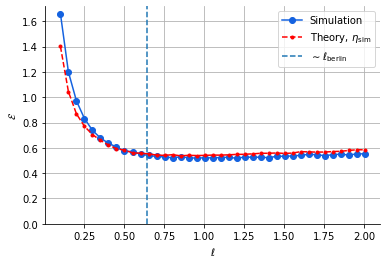

In [23]:
%matplotlib inline
save_figs = False

fig, ax = plt.subplots()
xlabel = r"$\ell$"
x_rescaled = df["l"].to_numpy()
# print(x)
# x_rescaled = ell_list
# Ci_old = Ci

Ci_data_drt = df["cummulative_drt_bimodal"]/cummulative_car
Ci_data_car = df["cummulative_car_bimodal"]/cummulative_car
Ci_data_pt = R0*df["cummulative_train_bimodal"]/cummulative_car
Ci_data =  Ci_data_drt + Ci_data_car + Ci_data_pt

ax.plot(x_rescaled, Ci_data, 'o-', label="Simulation", color='#1462e0')
# ax.plot(x_rescaled, Ci_data_drt, 'o-', color='orange', label="Simulation drt contribution")
# ax.plot(x_rescaled, Ci_data_pt, 'o-', color='green', label="Simulation pt contribution")
# ax.plot(x_rescaled, Ci_data_car, 'o-', color='coral', label="Simulation car contribution")

argmin_data = np.argmin(Ci_data)
x_parab = x_rescaled[np.array([argmin_data - 1, argmin_data, argmin_data + 1])]
y_parab = Ci_data.to_numpy()[np.array([argmin_data - 1, argmin_data, argmin_data + 1])]
print("Min of C_I with R0=", round(R0,2), "at: ", x_rescaled[np.argmin(Ci_data)]
      ,", better: ", getMinAroundMin(x_rescaled, Ci_data.to_numpy()), "value: ", np.min(Ci_data))
# ax.axvline(getMinAroundMin(x_rescaled, Ci_data.to_numpy()), ls="--")
print("Min of C_I (th) with R0=", round(R0,2), "at: ", x_rescaled[np.argmin(Ci_theory)],
     "better: ", getMinAroundMin(x_rescaled, Ci_theory))
print("Min of C_I (th_bi) with R0=", round(R0,2), "at: ", x_rescaled[np.argmin(Ci_theory_bi)],
     "better: ", getMinAroundMin(x_rescaled, Ci_theory_bi))
print("Min of C_I (th_mft) with R0=", round(R0,2), "at: ", x_rescaled[np.argmin(Ci_theory_mft)],
     "better: ", getMinAroundMin(x_rescaled, Ci_theory_mft))

# ax.axvline(x_rescaled[np.argmin(Ci_data)], c='#1462e0')
# ax.axvline(x_rescaled[np.argmin(Ci_theory)], c="r")
# ax.axvline(x_rescaled[np.argmin(Ci_theory_mft)], c="green")
#TODO find minimum with fit parabola
# filtered = savgol_filter(Ci_data, window_length=3, polyorder=1)

ax.plot(x_rescaled, Ci_theory, "--o", c='r', label=r"Theory, $\eta_\mathrm{sim}$", ms=3)
ax.axvline(0.64, ls="--", label=r"$\sim\ell_\mathrm{berlin}$")
# ax.axvline(0.47, ls="--", label=r"$\sim\ell_\mathrm{manhattan}$")
# ax.plot(x_rescaled, filtered, "--", c="red")
# ax.plot(x_rescaled, Ci_theory_bi, "--", c='orange', label=r"Theory, $\langle\delta\rangle(\langle b\rangle_\mathrm{sim}, \delta_{max})$")
# ax.plot(x_rescaled, Ci_theory_mft, "--", c='green', label=r"Theory, $\langle\delta\rangle_\mathrm{mft}(\langle b\rangle_\mathrm{sim}, \delta_{max})$")
# ax.plot(x_rescaled, Ci_theory_drt, "o--", c='orange', label="Theory drt contribution")
# ax.plot(x_rescaled, Ci_theory_pt, "o--", c='green', label="Theory pt contribution")
# ax.plot(x_rescaled, Ci_theory_car, "o--", c='coral', label="Theory car contribution")
ax.set_ylabel("$\mathcal{E}$")
# print(Ci_data/Ci)
# print(ell_list[np.argmin(Ci)])
ax.set_xlabel(xlabel)
ax.legend()
ax.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim(0,None)

# fig.savefig("Figures/EmissionsVaryinglBerlin3Eps0.pgf")
# fig.savefig("Figures/EmissionsVaryinglManhattan.pgf")

plt.show()

Simulation min of C_I with R0= 4 at:  0.7012827356086616
Theory min of C_I with R0= 4 at:  0.5510078636925198
Simulation min of C_I with R0= 7 at:  1.202198975329134
Theory min of C_I with R0= 7 at:  0.8515576075248034


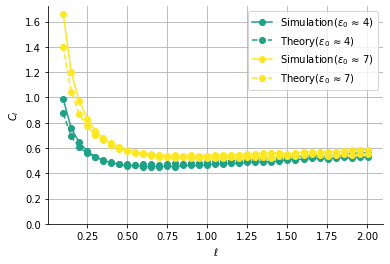

In [25]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('viridis')

Ci_data_drt = df["cummulative_drt_bimodal"]/cummulative_car
Ci_data_car = df["cummulative_car_bimodal"]/cummulative_car
for R0 in [4, 7]:
    Ci_data_pt = R0*df["cummulative_train_bimodal"]/cummulative_car
    Ci_data = Ci_data_drt+Ci_data_car+Ci_data_pt
    Ci_theory_mft, Ci_theory_pt, Ci_theory_drt, Ci_theory_car,_ = getCarbonIndexVectorized(
        x, f, df["av_drt_occs_non_standing"], delta_av_theory, R0
    )
    Ci_theory,_,_,_,_ = getCarbonIndexVectorized(
        x, f, df["av_drt_occs_non_standing"], df["av_detours"], R0
    )
    Ci_data = (
        df["cummulative_car_bimodal"]
        + df["cummulative_drt_bimodal"]
        + R0 * df["cummulative_train_bimodal"]
    ) / cummulative_car
    ax.plot(x_rescaled, Ci_data, "o-", label="Simulation"+r"($\epsilon_0$ ≈ {})".format(round(R0, 1)), color=cmap(R0/7))
    ax.plot(x_rescaled, Ci_theory, "o--", label="Theory"+r"($\epsilon_0$ ≈ {})".format(round(R0,1)), color=cmap(R0/7))
#     ax.plot(x_rescaled, Ci_theory_mft, "o", ls='dotted',label="Theory (R0 ≈ {})".format(round(R0,1)), color=cmap(R0/7))
#     ax.axvline(x_rescaled[np.nanargmin(Ci_data)], color=cmap(R0/7), ls=(0, (1, 1)))
#     ax.axvline(x_rescaled[np.nanargmin(Ci_theory)], color=cmap(R0/7), ls=(0, (3, 10, 1, 10)))
    print("Simulation min of C_I with R0=", round(R0,2), "at: ", x_rescaled[np.argmin(Ci_data)])
    print("Theory min of C_I with R0=", round(R0,2), "at: ", x_rescaled[np.argmin(Ci_theory)])

# newx = np.linspace(x[-1], 1, 10)
# newCi_theory, _, _, _ = getCarbonIndex(newx, [f[-1] for _ in newx], [av_drt_occs_non_standing[-1] for _ in newx], [av_detours[-1] for _ in newx], 7)
# print(newx/D)
# print(Ci_theory)
# ax.plot(newx/D, newCi_theory, "o--")


ax.set_xlabel(xlabel)
ax.grid()
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$C_I$")

ax.set_ylim((0,None))
# print(Ci_data)

# save_figs=True
if save_figs:
    fig.savefig("CarbonIdxVaryinglAndR0SimTheo.png", dpi=200)
#     fig.savefig("CarbonIdxVaryinglAndR0SimTheo.pdf")
plt.show()

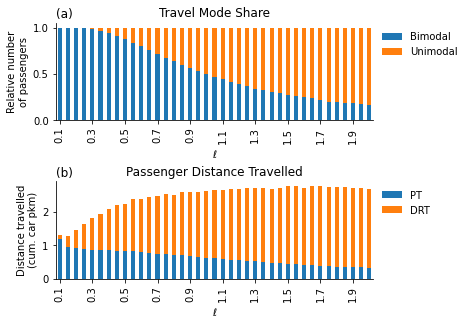

In [281]:
fig, axes = plt.subplots(2,1,constrained_layout=True, figsize=(6.4, 4.4))

# fig, ax = plt.subplots(constrained_layout=True)
ax = axes[0]

df["dcut_rounded"] = np.round(df["dcut"], 1)
df["l_rounded"] = np.round(df["l"], 1)

# bi_or_unimodal.set_index(round(1/bi_or_unimodal.reset_index()["index"]), inplace=True)
# bi_or_unimodal.set_index(np.round(x_rescaled, decimals=2), inplace=True)
# bi_or_unimodal = df.loc[:,["pt_usage_count", "non_pt_usage_count"]]
# bi_or_unimodal.plot.bar(ax = ax, xlabel=xlabel, ylabel="frequency")
n_passenger = df["pt_usage_count"] + df["non_pt_usage_count"]
df["pt_usage_frac"] = df["pt_usage_count"]/n_passenger
df["non_pt_usage_frac"] = df["non_pt_usage_count"]/n_passenger
df.plot.bar(ax = ax, x="l_rounded", y=["pt_usage_frac", "non_pt_usage_frac"], xlabel=r"$\ell$", ylabel="Relative number\nof passengers", stacked=True, legend=False)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

ax.set_title("Travel Mode Share")
ax.text(0.0, 1.05, "(a)", transform=ax.transAxes, fontsize="large")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
patches, labels = ax.get_legend_handles_labels()
labels = ["Bimodal", "Unimodal"]
ax.legend(patches, labels, frameon=False, bbox_to_anchor=(1.0, 1))
# ax.grid(axis="y")

# fig, ax = plt.subplots(constrained_layout=True)
ax = axes[1]

# bi_or_unimodal.set_index(round(1/bi_or_unimodal.reset_index()["index"]), inplace=True)
# drt_pt_person_km.set_index(np.round(x_rescaled, decimals=2), inplace=True)
# df.plot.bar(ax = ax, x="dcut_rounded", y=["cummulative_drt_bimodal", "cummulative_train_bimodal"], xlabel=r"$d_\mathrm{cut}$", ylabel="meter travelled")
df["pkm_drt_norm"] = df["pkm_drt"]*1000 / dists_car.sum()
df["pkm_pt_norm"] = df["pkm_pt"]*1000 / dists_car.sum()
df.plot.bar(ax = ax, x="l_rounded", y=["pkm_pt_norm", "pkm_drt_norm"], xlabel=r"$\ell$", ylabel="Distance travelled\n(cum. car pkm)", stacked=True, legend=False)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.text(0.0, 1.05, "(b)", transform=ax.transAxes, fontsize="large")


patches, labels = ax.get_legend_handles_labels()
labels = ["PT", "DRT"]
ax.legend(patches, labels, frameon=False, bbox_to_anchor=(1.0, 1))
# labels=["PT", "DRT"]
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,0.), ncol=2, frameon=False)
# ax.legend()

ax.set_title("Passenger Distance Travelled")
# ax.grid(axis="y")

# fig.savefig("Figures/BarPlotsPtDrt.pgf", bbox_inches="tight")
plt.show()

#### Constant DRT Demand Simulations

$\mathrm{DRT\_demand}=\frac{\nu \langle d\rangle}{v_\mathrm{drt}}$

$\langle d\rangle = \langle r_{\leq d_\mathrm{cut}}\rangle F_r + 2\beta\ell \bar{F}_r$

Choosing
$\nu = \frac{\mathrm{const}}{\langle d\rangle}$ so that drt demand stays constant

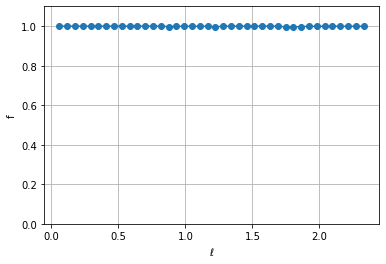

In [44]:
fig, ax = plt.subplots()

ax.plot(x_rescaled, df["serviced_fracts"], 'o-')
ax.set_ylabel("f")
ax.set_xlabel(xlabel)

ax.set_ylim((0,1.1))
ax.grid()

if save_figs:
    fig.savefig("ServicedFraction.png", dpi=200)
plt.show()

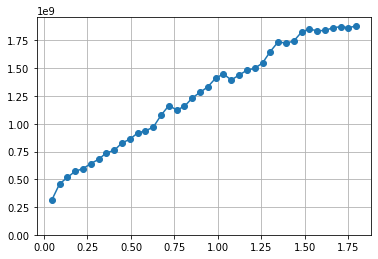

In [45]:
fig, ax = plt.subplots()

ell_renorm = df["l"] * 1000/10000
dcut_renorm = df["dcut"] * 1000/10000
avDistFracToDCut = uniFracAvDist(dcut_renorm)*10000
avDistFracFromDCut = bimFracAvDist(ell_renorm, dcut_renorm)*10000
# ax.plot(df["dcut"], df["effective_passenger_number"]*(aaa + bbb), 'o-')
ax.plot(df["dcut"], df["effective_passenger_number"]*df["drt_mean_dist"], 'o-')
# ax.plot(df["dcut"], df["effective_passenger_number"]*bla, 'o-')
# ax.plot(df["dcut"], df["effective_passenger_number"], 'o-')
# ax.plot(df["dcut"], df["drt_mean_dist"], 'o-')
# ax.plot(df["dcut"], aaa+bbb, 'o-')

# ax.plot(df["dcut"], df["av_detours"], 'o-')
# ax.set_xlabel("")
ax.set_ylim(0,None)

ax.grid()

plt.show()

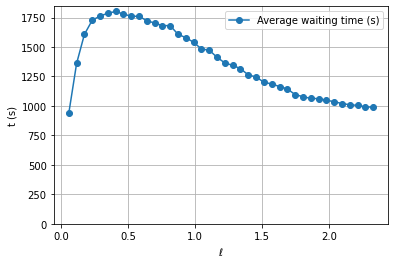

In [46]:
fig, ax = plt.subplots()

# def getWaitTimes(mu_s, link_tt, bi_uni_share, p_drt):
#     notp_d = 1-p_d
#     ptwait = 1/mu_s
#     drtwait = link_tt*sum([i*notp_d**(2*i*(i+1)) for i in range(1,100)])
#     twaits = bi_uni_share['Bimodal'] * (ptwait + 2*drtwait) + bi_uni_share['Unimodal'] * drtwait
#     return twaits, drtwait, ptwait
    
# bi_uni_share = bi_or_unimodal.divide(bi_or_unimodal.sum(axis=1), axis=0)
# mu_s = mu/(24*3600)
# link_tt = 200/(30/3.6)
# p_d = 300/10000
# totalwait, drtwait, ptwait = getWaitTimes(mu_s, link_tt, bi_uni_share, p_d)


ax.plot(x_rescaled, df["wait_times"], 'o-', label="Average waiting time (s)")
# ax.plot(x_rescaled, totalwait, 'o--')
ax.set_ylabel("t (s)")
ax.set_xlabel(xlabel)
# ax.set_ylim((0,wait_times.max()*1.1))
ax.legend()
ax.grid()
ax.set_ylim(0,None)

if save_figs:
    fig.savefig("AverageWaitingTime.png", dpi=200)
plt.show()

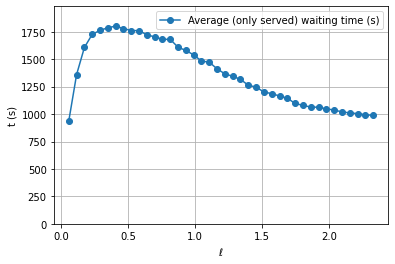

In [47]:
fig, ax = plt.subplots()

ax.plot(x_rescaled, df["wait_times_served_only"], 'o-', label="Average (only served) waiting time (s)")
# ax.plot(x_rescaled, totalwait, 'o--')
ax.set_ylabel("t (s)")
ax.set_xlabel(xlabel)
ax.set_ylim((0,df["wait_times"].max()*1.1))
ax.grid()
ax.legend()

save_figs=False
if save_figs:
    fig.savefig("AverageWaitingTimeServed.png", dpi=200)
plt.show()

In [48]:
print(v_drt)

2.765996680803983


0.9016492314968506


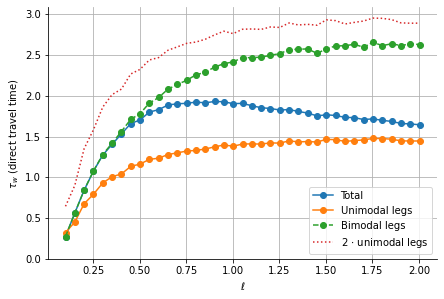

In [282]:
fig, ax = plt.subplots(constrained_layout=True)

# test = (av_drt_occs - av_drt_occs.min()) /(av_drt_occs.max() - av_drt_occs.min())
def getWaitingTimeApprox(ell, dcut, detours):
    dcut_ = dcut * mean_req_dist/10000
    ell_ = ell * mean_req_dist/10000
    d_bi = bimFrac(dcut_)/4*detours*beta*ell_
    d_uni = detours/3*uniFracAvDist(dcut_)
    tw = (d_bi+d_uni)/v_drt*3600
    return tw

# print(test)
print(x_rescaled[np.argmax(df["drt_wait_times"].to_numpy())])
ax.plot(x_rescaled, df["drt_wait_times"]/tt_car, '-o', label='Total')
# ax.plot(x_rescaled, (df["drt_wait_times"]+df["drt_wait_times_std"])/tt_car, '-o', label='Test')
ax.plot(x_rescaled, df["wait_times_drt_unimodal_legs"]/tt_car, 'o-', label="Unimodal legs")
ax.plot(x_rescaled, df["wait_times_drt_bimodal_legs"]/tt_car, 'o--', label="Bimodal legs")
ax.plot(x_rescaled, 2*df["wait_times_drt_unimodal_legs"]/tt_car, ':', label="2 $\cdot$ unimodal legs")

# ax.plot(x_rescaled, df["av_drt_occs_non_empty"]*rt_bimodal/2, 'o:', label="Test")
# ax.plot(x_rescaled, df["av_drt_occs_non_standing"]*drt_rt*1/2, 'o:', label="Prediction")
# ax.plot(x_rescaled, av_drt_occs_non_standing*ride_times_drt_unimodal_legs*1/2, 'o:', label="Test")
# ax.plot(x_rescaled, getWaitingTimeApprox(df["l"].to_numpy(),
#                                          df["dcut"].to_numpy(),
#                                          df["av_detours"].to_numpy())/tt_car, 'o:', label="Prediction")

# ax.plot(x_rescaled, [drtwait for _ in x], '--o')
ax.set_ylabel(r"$\tau_w$ (direct travel time)")
ax.set_xlabel(xlabel)
ax.set_ylim(0,None)
ax.legend(loc='lower right')
ax.grid()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# if save_figs:
# fig.savefig("Figures/DrtWaitingTimeCompBimodal.pgf")
# fig.savefig("Figures/DrtWaitingTimeCompBimodalManhattan.pgf")
# fig.savefig("Figures/DrtWaitingTimeCompBimodalBerlin.pgf")

plt.show()

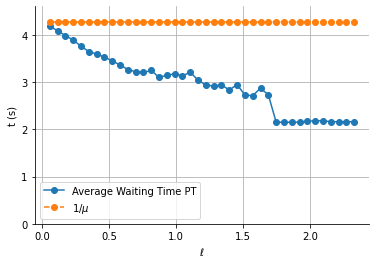

In [23]:
fig, ax = plt.subplots()

# test = (av_drt_occs - av_drt_occs.min()) /(av_drt_occs.max() - av_drt_occs.min())
# print(test)
ptwait = 1/(mu/3600)
# Pt wait times are only averaged over people who use pt so wait_times != pt_wait_times + drt_wait_times
ptwait_sim_norm = df["pt_wait_times"]/tt_car
ax.plot(x_rescaled, ptwait_sim_norm, '-o', label='Average Waiting Time PT')
ax.plot(x_rescaled, [ptwait for _ in x]/tt_car, '--o', label=r'$1/\mu$')
ax.set_ylabel("t (s)")
ax.set_xlabel(xlabel)
ax.set_ylim(0,ptwait_sim_norm.max()*1.1)
ax.legend()
ax.grid()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

if save_figs:
    fig.savefig("PtWaitingTime.png", dpi=200)

plt.show()

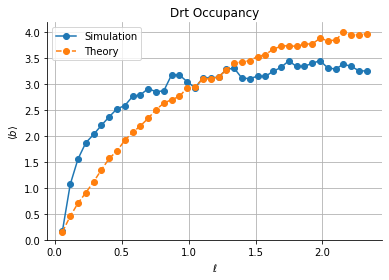

In [24]:
fig, ax = plt.subplots()

occupancy_theory = np.vectorize(getDrtNonEmptyOccupancy)(x, x, v_drt, 1500, df["av_detours"])

ax.plot(x_rescaled, df["av_drt_occs"], 'o-', label="Simulation")
ax.plot(x_rescaled, occupancy_theory, 'o--', label="Theory")
ax.set_ylabel(r"$\langle b\rangle$")
ax.set_xlabel(xlabel)
ax.set_ylim(0,None)
ax.grid()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Drt Occupancy")
ax.legend()

if save_figs:
    fig.savefig("AverageOccupancy.png", dpi=200)
# fig.savefig("Figures/AverageDrtOccupancy.pgf")
plt.show()

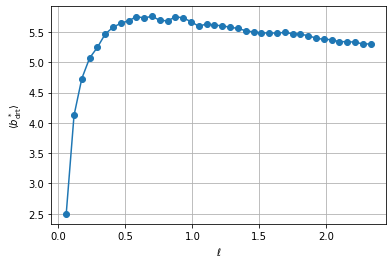

In [25]:
fig, ax = plt.subplots()
#TODO fix this

ax.plot(x_rescaled, df["av_drt_occs_non_empty"], 'o-')
ax.set_ylabel(r"$\langle b_\mathrm{drt}^*\rangle$")
ax.set_xlabel(xlabel)
ax.grid()

if save_figs:
    fig.savefig("AverageNonEmptyOccupancy.png", dpi=200)
plt.show()

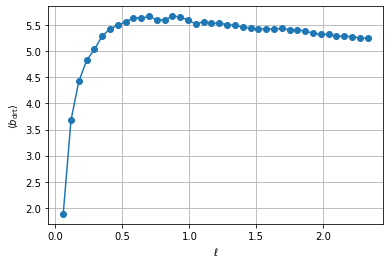

In [26]:
fig, ax = plt.subplots()

ax.plot(x_rescaled, df["av_drt_occs_non_standing"], 'o-')
ax.set_ylabel(r"$\langle b_\mathrm{drt}\rangle$")
ax.set_xlabel(xlabel)
ax.grid()

if save_figs:
    fig.savefig("AverageNonStandingOccupancy.png", dpi=200)
plt.show()

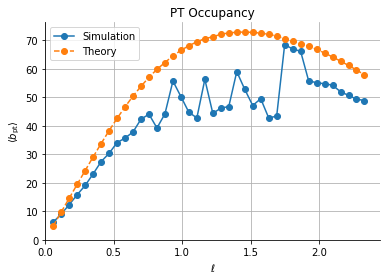

In [27]:
fig, ax = plt.subplots()

# Difference to theory for InvGamma comes from periodic BC

ax.plot(x_rescaled, df["av_pt_occs"], 'o-', label="Simulation")

# ax.plot(ell_list, tram_occs_theory[:,1], "o--", c='r', label="Theory computed by"+r" $\langle n\rangle$")
# ax.plot(ell_list, tram_occs_theory[:,0], "o--", c='g', label="Theory computed by"+r" $\tilde{I}$")
ax.plot(x_rescaled, tram_occs_theory[:,1], "o--", label="Theory")
ax.legend()
ax.grid()

ax.set_ylabel(r"$\langle b_\mathrm{pt}\rangle$")
ax.set_xlabel(xlabel)
ax.set_xlim(0,None)
ax.set_ylim(0,None)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("PT Occupancy")

if save_figs:
    fig.savefig("AveragePtOccupancy.png", dpi=200)
# fig.savefig("Figures/AveragePtOccupancy.pgf")
plt.show()

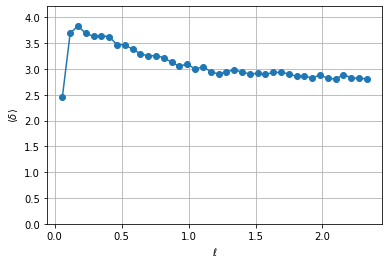

In [28]:
fig, ax = plt.subplots()

ax.plot(x_rescaled, df["av_detours"], 'o-')
ax.set_ylabel(r"$\langle \delta\rangle$")
ax.set_xlabel(xlabel)

ax.set_ylim((0,df["av_detours"].max()*1.1))
ax.grid()

save_figs=True
if save_figs:
    fig.savefig("AverageDrtDetour.png", dpi=200)
plt.show()

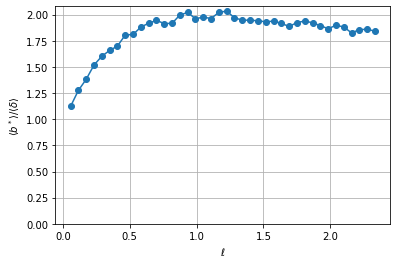

In [79]:
fig, ax = plt.subplots()

ax.plot(x_rescaled, df["av_drt_occs_non_empty"]/df["av_detours"], 'o-')
ax.set_ylabel(r"$\langle b^*\rangle/\langle\delta\rangle$")
ax.set_xlabel(xlabel)

ax.set_ylim((0,None))
ax.grid()

if save_figs:
    fig.savefig("BOverDelta.png", dpi=200)
plt.show()

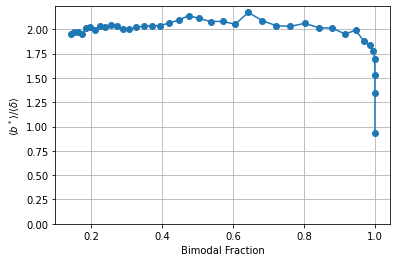

In [80]:
fig, ax = plt.subplots()

bimodal_frac = np.vectorize(bimFrac)(df["dcut"]*df["mean_req_dist"]/10000)

# ax.plot(df["dcut"], df["av_drt_occs_non_standing"], 'o-')
# ax.plot(bimodal_frac, df["av_drt_occs_non_standing"]/df["av_detours"], 'o-')
ax.plot(bimodal_frac, df["cummulative_drt_unshared"]/df["cummulative_drt_bimodal"], 'o-')
ax.set_ylabel(r"$\langle b^*\rangle/\langle\delta\rangle$")
ax.set_xlabel("Bimodal Fraction")
# ax.set_xlabel(r"$d_\mathrm{cut}$")

ax.set_ylim((0,None))
ax.grid()

if save_figs:
    fig.savefig("figures/BStarOverDelta.png", dpi=200)
plt.show()

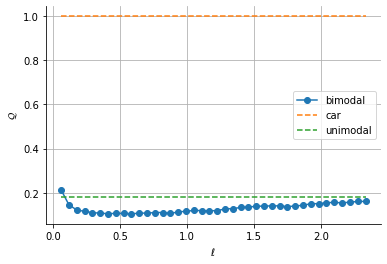

In [81]:
fig, ax = plt.subplots()

ax.plot(x_rescaled, tt_car/df["tt_bimodal"], 'o-', label='bimodal')
ax.plot(x_rescaled, [1 for _ in x_rescaled], '--', label='car')
ax.plot(x_rescaled, tt_car/[tt_unimodal for _ in x_rescaled], '--', label='unimodal')
ax.set_ylabel(r"$\mathcal{Q}$")
ax.set_xlabel(xlabel)
ax.legend()
# ax.set_ylim(0,1.1*df["tt_bimodal"].max())
ax.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# print(tt_unimodal/tt_car)
# print(tt_bimodal/tt_car)

save_figs=True
if save_figs:
    fig.savefig("AverageTravelTimes.png", dpi=200)
fig.savefig("Figures/QualityVaryEll.pgf")
plt.show()

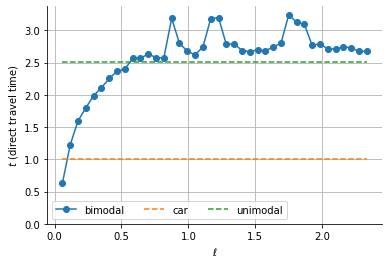

In [82]:
fig, ax = plt.subplots()

rt_bimodal = df["tt_bimodal"]-df["wait_times"]
ax.plot(x_rescaled, rt_bimodal/tt_car, 'o-', label='bimodal')
ax.plot(x_rescaled, [tt_car for _ in x_rescaled]/tt_car, '--', label='car')
ax.plot(x_rescaled, [tt_unimodal-wait_time_unimodal for _ in x_rescaled]/tt_car, '--', label='unimodal')
ax.set_ylabel(r"$t$ (direct travel time)")
ax.set_xlabel(xlabel)
ax.legend(ncol=3)
# ax.set_ylim(0,1.1*tt_bimodal.max())
ax.grid()
ax.set_ylim(0,None)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

if save_figs:
    fig.savefig("AverageRideTimes.png", dpi=200)
# fig.savefig("Figures/AverageRideTimesVaryEll.pgf")
plt.show()

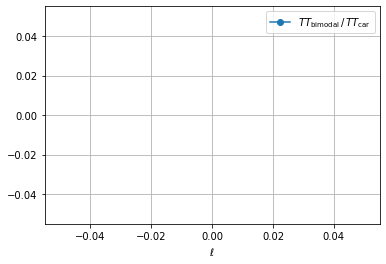

In [32]:
fig, ax = plt.subplots()

ax.plot(x_rescaled, df["tt_ratios_beyond_lcut"], 'o-', label=r"$TT_\mathrm{bimodal}\,/\,TT_\mathrm{car}$")
ax.set_xlabel(xlabel)
ax.legend()
ax.grid()

if save_figs:
    fig.savefig("TTRatiosBeyondLCut.png", dpi=200)
plt.show()

# Whats happening at peak?

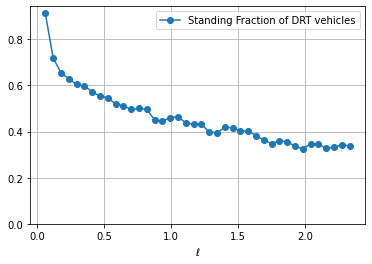

In [33]:
fig, ax = plt.subplots()

ax.plot(x_rescaled, df["standing_fraction"], 'o-', label="Standing Fraction of DRT vehicles")
ax.set_xlabel(xlabel)
ax.legend()
ax.grid()
ax.set_ylim(0,None)

save_figs=True
if save_figs:
    fig.savefig("StandingDrtFraction.png", dpi=200)
plt.show()

In [34]:
%matplotlib inline
ph_modestats.plot.area()

plt.figure()
pkm_modestats.plot.area()
plt.show()

NameError: name 'ph_modestats' is not defined

# Debug

In [ ]:
plt.figure()
plt.scatter(ell_list, tram_occs_theory[:,0], label='int')
plt.scatter(ell_list, tram_occs_theory[:,1], label='av')
plt.legend()

plt.show()

In [ ]:
a = np.array(["a1","a2","a3","a4","a5"])
b = np.array(["b1","b2"])
c = np.array(["c1","c2","c3","c4","c5"])
d = np.array(["d1","d2"])

for i in range(len(a)*len(b)*len(c)*len(d)):
    i1 = i%len(a)
    h1 = i//len(a)
    i2 = h1%len(b)
    h2 = h1//len(b)
    i3 = h2%len(c)
    h3 = h2//len(c)
    i4 = h3%len(b)
    print(a[i1], b[i2], c[i3], d[i4])